![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-ocr-workshop/blob/master/tutorials/Certification_Trainings/1.1.Text_recognition.ipynb)

## Blogposts and videos

- [Text Detection in Spark OCR](https://medium.com/spark-nlp/text-detection-in-spark-ocr-dcd8002bdc97)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Extract Tabular Data from PDF in Spark OCR](https://medium.com/spark-nlp/extract-tabular-data-from-pdf-in-spark-ocr-b02136bc0fcb)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)


**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

For get the trial license please go to:

https://www.johnsnowlabs.com/install/

In [ ]:
# NBVAL_SKIP
import json, os
import sys

if 'google.colab' in sys.modules:
    from google.colab import files

    if 'spark_ocr.json' not in os.listdir():
      license_keys = files.upload()
      os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# NBVAL_SKIP
# Installing pyspark and spark-nlp
%pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
#! pip uninstall spark-ocr -Y
%pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [2]:
SPARK_OCR_SECRET = ""

In [1]:
# NBVAL_SKIP
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [3]:
import pkg_resources

from pyspark.ml import PipelineModel
from pyspark.sql import functions as F

from sparkocr import start
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import *
from sparkocr.metrics import score

In [6]:
spark_ocr_jar_path = "../../../target/scala-2.12/"

In [7]:
# Start spark
spark = start(secret=SPARK_OCR_SECRET, jar_path=spark_ocr_jar_path)

Spark version: 3.4.1
Spark NLP version: 5.1.2
Spark OCR version: 5.1.2rc5



## Image to Text


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 199 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


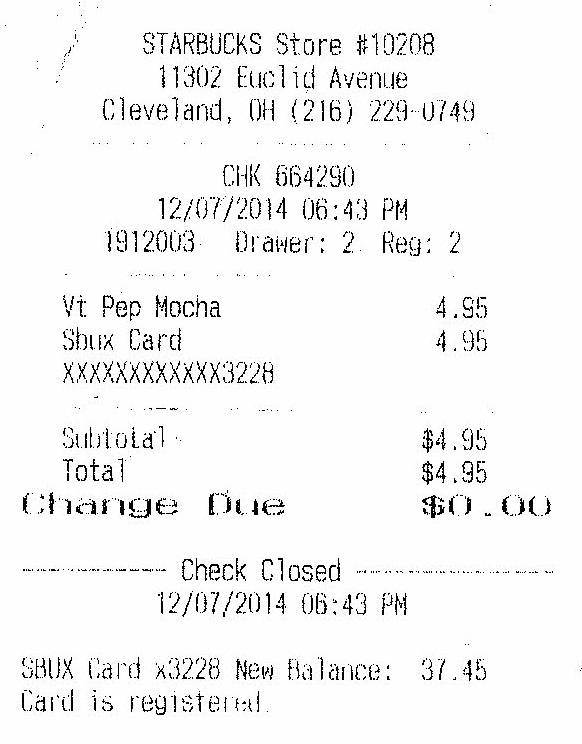

In [4]:
image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/check.jpg')
image_example_df = spark.read.format("binaryFile").load(image_path).cache()

display_images(BinaryToImage().transform(image_example_df))

In [5]:
binary_to_image = BinaryToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)
      #.setKeepLayout(True) # to preserve the layout of the input

image_to_text_pipeline = PipelineModel(stages=[
    binary_to_image,
    ocr
])

In [30]:
result = image_to_text_pipeline.transform(image_example_df).cache()
result.select("pagenum", "text", "confidence").show()

result.printSchema()

+-------+--------------------+-----------------+
|pagenum|                text|       confidence|
+-------+--------------------+-----------------+
|      0|STARBUCKS Store #...|71.79433135986328|
+-------+--------------------+-----------------+

root
 |-- image: struct (nullable = true)
 |    |-- origin: string (nullable = true)
 |    |-- height: integer (nullable = false)
 |    |-- width: integer (nullable = false)
 |    |-- nChannels: integer (nullable = false)
 |    |-- mode: integer (nullable = false)
 |    |-- resolution: integer (nullable = false)
 |    |-- data: binary (nullable = true)
 |-- path: string (nullable = true)
 |-- modificationTime: timestamp (nullable = true)
 |-- length: long (nullable = true)
 |-- pagenum: integer (nullable = true)
 |-- confidence: double (nullable = true)
 |-- exception: string (nullable = true)
 |-- text: string (nullable = true)
 |-- positions: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- mapping: array

In [7]:
print("\n".join([row.text for row in result.select("text").collect()]))

STARBUCKS Store #19208
11902 Euclid Avenue
Cleveland, OH (216) 229-U749

CHK 664250
12/07/2014 06:43 PM
112003. Drawers 2. Reg: 2

¥t Pep Mocha 4.5
Sbux Card 495
AMXARKERARANG 228
Subtotal $4.95
Total $4.95
Change Cue BO LOO
- Check Closed ~

oBUX Card «3228 New Balance: 37.45
Card is registertd



## Image to HOCR

In [8]:
def pipeline():
    
    # Transforrm PDF document to images per page
    binary_to_image = BinaryToImage() \
        .setInputCol("content") \
        .setOutputCol("image") \
        .setImageType(ImageType.TYPE_3BYTE_BGR)

    # Run OCR
    ocr = ImageToHocr() \
        .setInputCol("image") \
        .setOutputCol("hocr") \
        .setIgnoreResolution(False)
    
    document_assembler = HocrDocumentAssembler() \
        .setInputCol("hocr") \
        .setOutputCol("document")

    tokenizer = HocrTokenizer() \
        .setInputCol("hocr") \
        .setOutputCol("token") \

    draw_annotations = ImageDrawAnnotations() \
        .setInputCol("image") \
        .setInputChunksCol("token") \
        .setOutputCol("image_with_annotations") \
        .setFilledRect(False) \
        .setFontSize(10) \
        .setRectColor(Color.red)
    
    pipeline = PipelineModel(stages=[
        binary_to_image,
        ocr,
        document_assembler,
        tokenizer,
        draw_annotations
    ])
    
    return pipeline

### Run pipeline and show results

In [9]:
result = pipeline().transform(image_example_df).cache()
print(result.select("hocr").collect()[0].hocr)

  <div class='ocr_page' id='page_1' title='image ""; bbox 0 0 582 744; ppageno 0'>
   <div class='ocr_carea' id='block_1_1' title="bbox 103 32 474 124">
    <p class='ocr_par' id='par_1_1' lang='eng' title="bbox 103 32 474 124">
     <span class='ocr_line' id='line_1_1' title="bbox 143 32 434 56; baseline 0.003 -2; x_size 29.5; x_descenders 5.5; x_ascenders 6.8571429">
      <span class='ocrx_word' id='word_1_1' title='bbox 143 32 261 55; x_wconf 96'>STARBUCKS</span>
      <span class='ocrx_word' id='word_1_2' title='bbox 277 33 341 56; x_wconf 96'>Store</span>
      <span class='ocrx_word' id='word_1_3' title='bbox 357 33 434 55; x_wconf 92'>#19208</span>
     </span>
     <span class='ocr_line' id='line_1_2' title="bbox 160 65 407 89; baseline 0 -1; x_size 28.454166; x_descenders 5.4541669; x_ascenders 6">
      <span class='ocrx_word' id='word_1_4' title='bbox 160 65 221 88; x_wconf 86'>11902</span>
      <span class='ocrx_word' id='word_1_5' title='bbox 238 65 315 89; x_wconf 96'>E

### Display recognized text on original image


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/images/check.jpg
    Resolution: 0 dpi
    Width: 582 px
    Height: 744 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


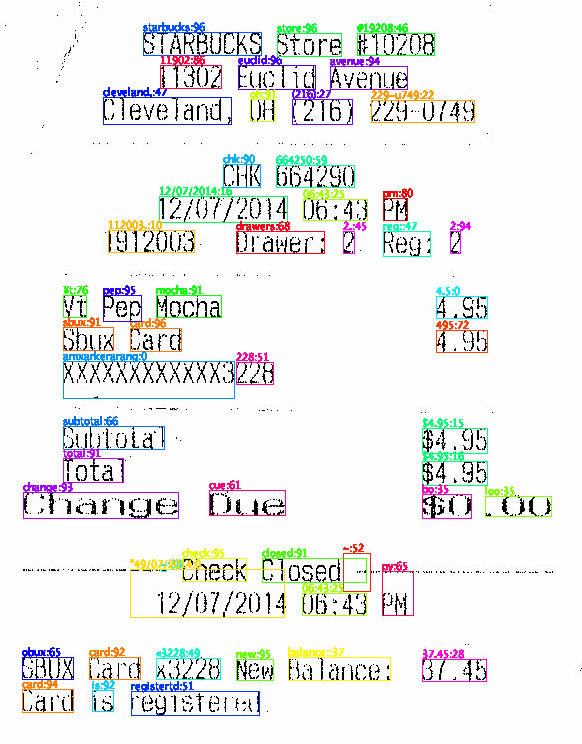

In [10]:
display_images(result, "image_with_annotations", width=1000)

## Pdf to Text

In [ ]:
pdf_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/test_document.pdf')
pdf_example_df = spark.read.format("binaryFile").load(pdf_path).cache()

display_pdf(pdf_example_df)

In [12]:
# Transform PDF document to images per page
pdf_to_image = PdfToImage()\
      .setInputCol("content")\
      .setOutputCol("image")

# Run OCR
ocr = ImageToText()\
      .setInputCol("image")\
      .setOutputCol("text")\
      .setConfidenceThreshold(65)

pdf_to_text_pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr
])

In [13]:
result = pdf_to_text_pipeline.transform(pdf_example_df).cache()
result.select("pagenum", "text", "confidence").show()

+-------+--------------------+----------------+
|pagenum|                text|      confidence|
+-------+--------------------+----------------+
|      0|Patient Nam\nFina...|81.2276874118381|
|      1|Patient Name\nFin...|78.5234429732613|
+-------+--------------------+----------------+



In [14]:
print("\n".join([row.text for row in result.select("text").collect()]))

Patient Nam
Financial Numbe

Random Hospital Date of Birth

Patient Location

Chief Complaint
Shortness of breath

History of Present Illness

Patient is an 84-year-old male wilh a past medical history of hypertension, HFpEF last
known EF 55%, mild to moderate TA, pulmonary hypertension, permanent atrial
fibrillation on Eliquis, history of GI blesd, CK-M8, and anemia who presents with full weeks
oi ccneralized fatigue and fecling unwell. He also notes some shortness oi Breath and
worsening dyspnea willy minimal exerlion. His major complaints are shoulder and joint
pains. diffusely. He also complains of "bone pain’. He denics having any fevers or cnills.

e demes having any chest pain, palpitalicns, He denies any worse extremity
swelling than his baseline. He states he’s been compliant with his mcdications. Although
he stales he ran out of his Eliquis & few weeks ago. He denies having any blood in his
stools or mc!ena, although he does take iron pills and states his stools arc irequentl

## Skew correction


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/rotated/400/400_rot.pdf
    Resolution: 300 dpi
    Width: 2480 px
    Height: 3507 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


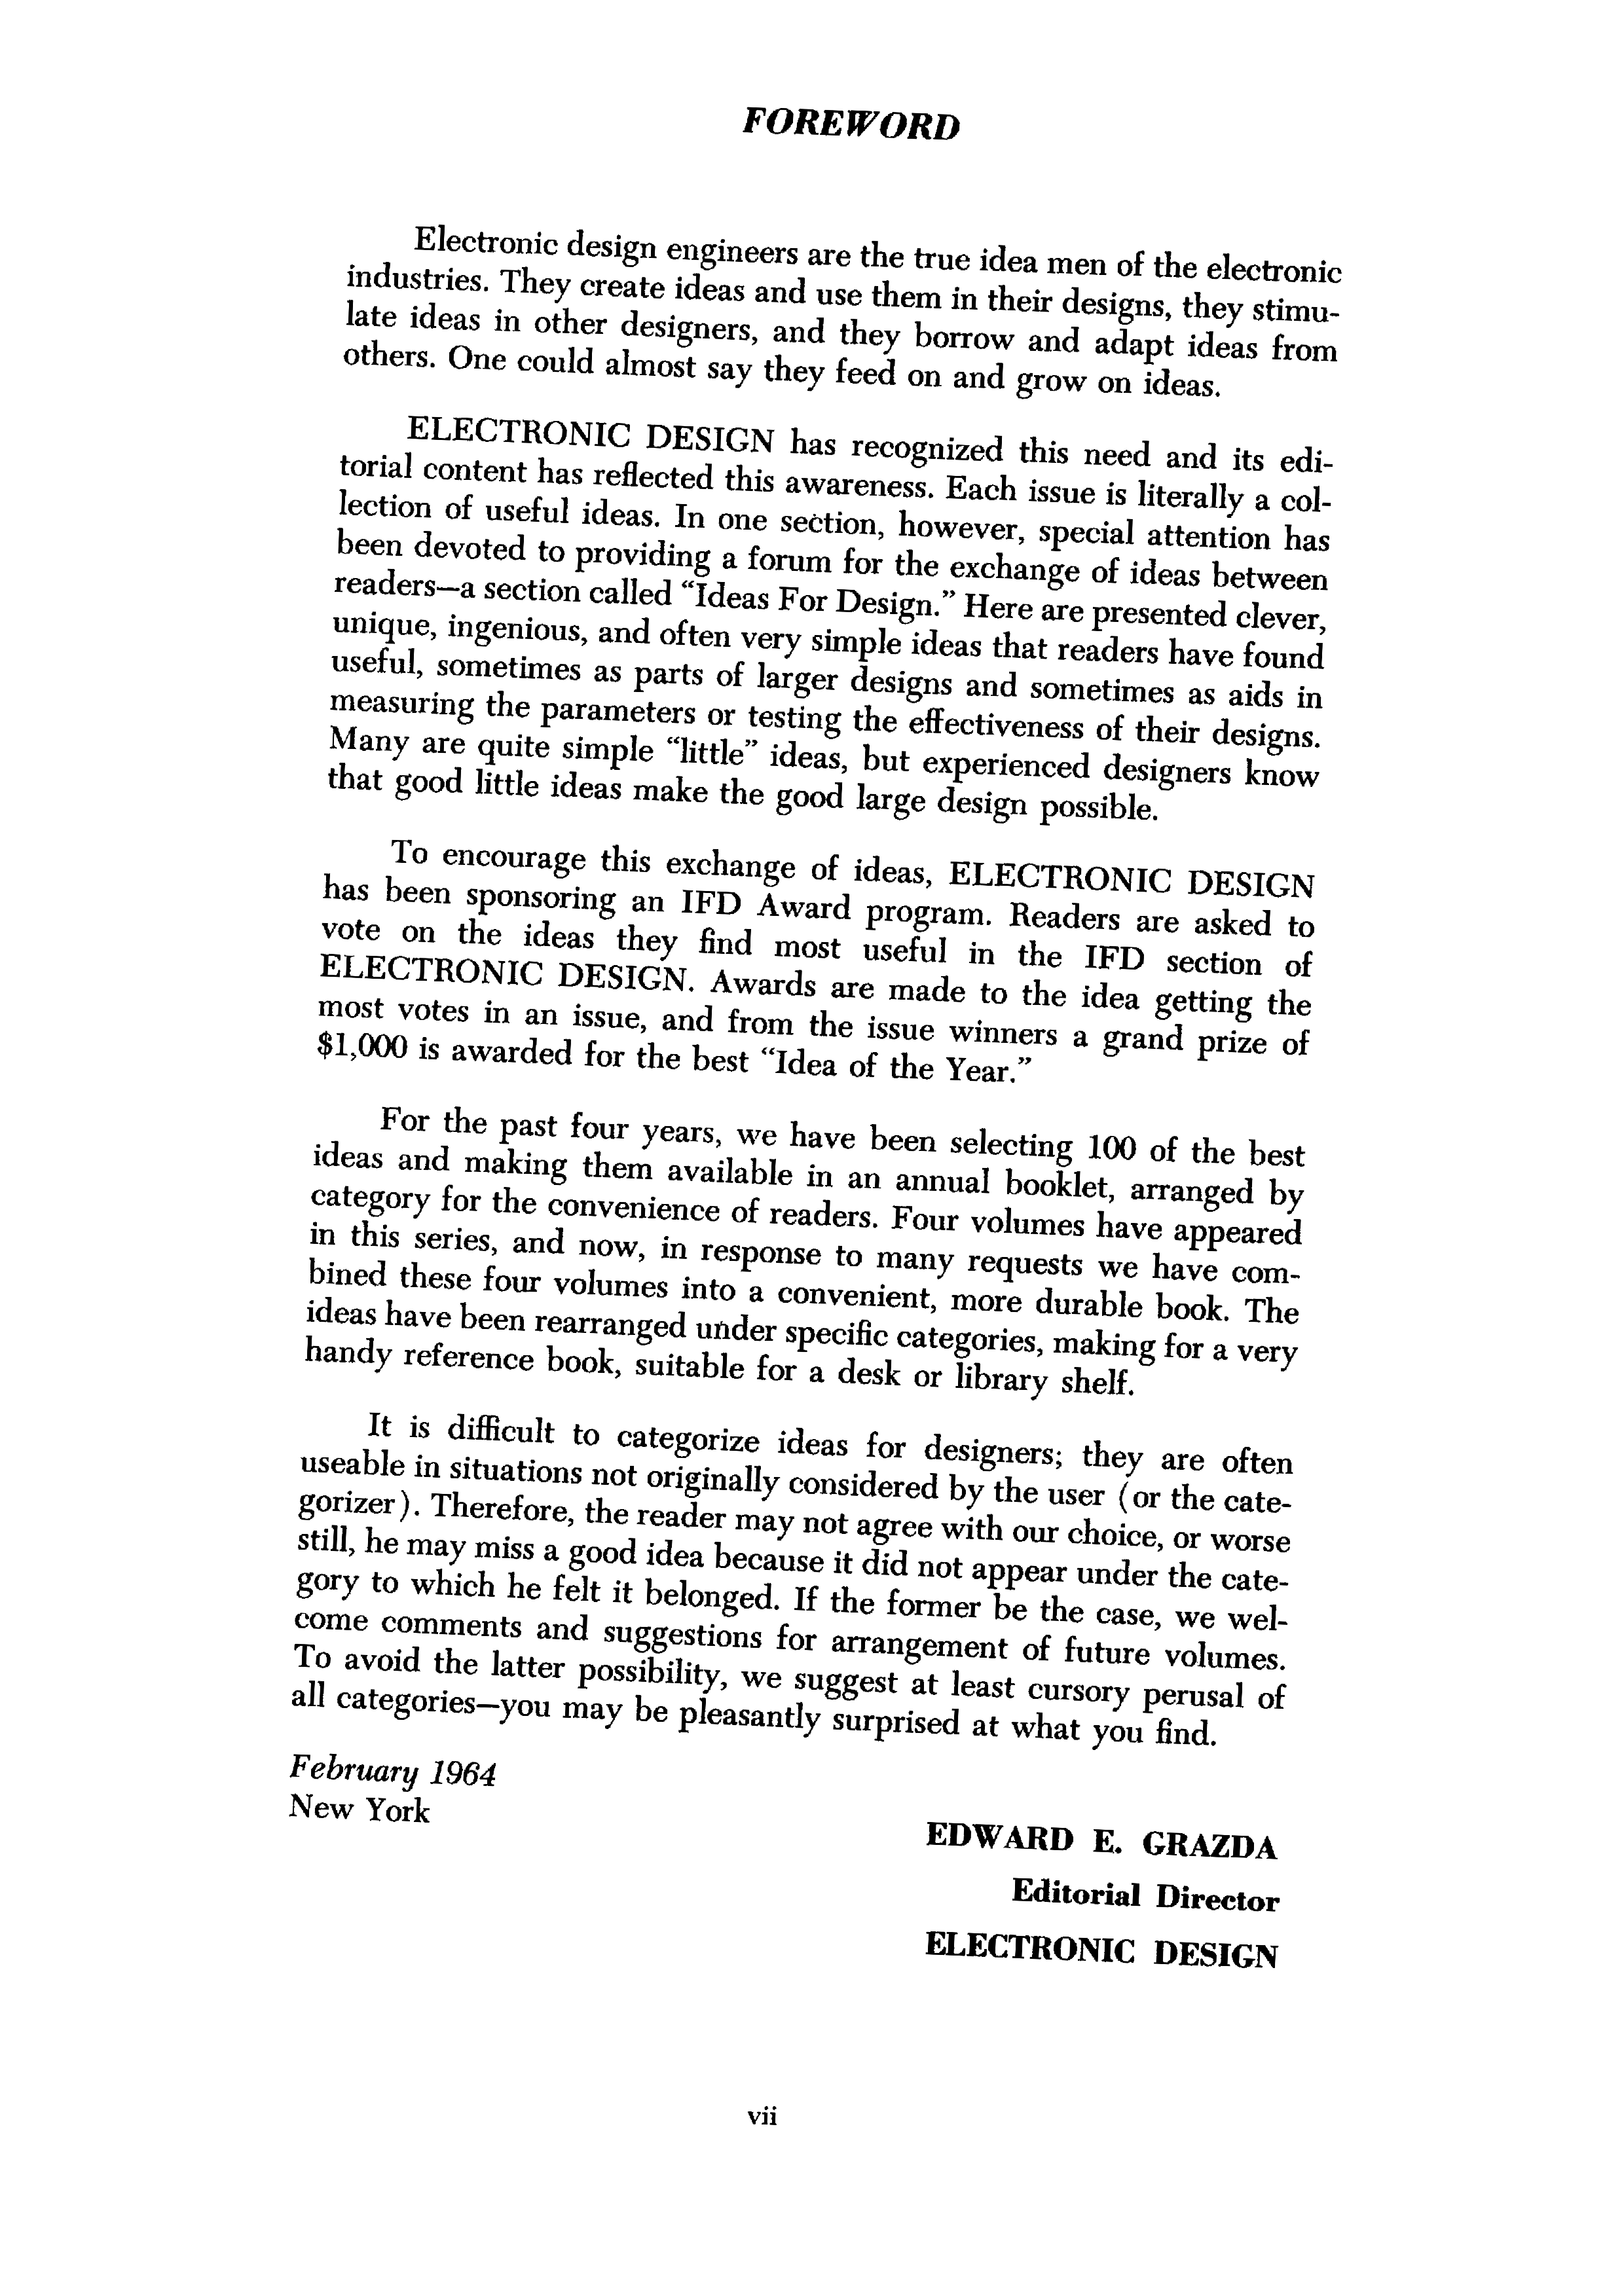

In [15]:
pdf_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/rotated/400/400_rot.pdf')
pdf_rotated_df = spark.read.format("binaryFile").load(pdf_path).cache()

display_pdf(pdf_rotated_df)

In [16]:
def ocr_pipeline(skew_correction=False):
    
    # Transforrm PDF document to images per page
    pdf_to_image = PdfToImage()\
          .setInputCol("content")\
          .setOutputCol("image")

    # Image skew corrector 
    skew_corrector = ImageSkewCorrector()\
          .setInputCol("image")\
          .setOutputCol("corrected_image")\
          .setAutomaticSkewCorrection(skew_correction)

    # Run OCR
    ocr = ImageToText()\
          .setInputCol("corrected_image")\
          .setOutputCol("text")
    
    pipeline_ocr = PipelineModel(stages=[
        pdf_to_image,
        skew_corrector,
        ocr
    ])
    
    return pipeline_ocr

In [17]:
result = ocr_pipeline(False).transform(pdf_rotated_df).cache()
print("\n".join([row.text for row in result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know

that good little ideas make the good large design possible.

To encourage this exchange of ideas, ELECTRONIC DESIGN
has been sponsoring an IFD Award program. Readers are asked to
vote on the ideas they find most useful in the IFD section of

most votes in an issue, and from the issue winners a grand prize of
$1,000 is awarded for the best “Idea of the Year.”

For the past four years, we have been selecting 100 of the best
ideas and making them available in an annual booklet, arranged by

It is difficul

In [18]:
corrected_result = ocr_pipeline(True).transform(pdf_rotated_df).cache()
print("\n".join([row.text for row in corrected_result.select("text").collect()]))

FOREWORD

Electronic design engineers are the true idea men of the electronic
industries. They create ideas and use them in their designs, they stimu-
late ideas in other designers, and they borrow and adapt ideas from
others. One could almost say they feed on and grow on ideas.

ELECTRONIC DESIGN has recognized this need and its edi-
torial content has reflected this awareness. Each issue is literally a col-
lection of useful ideas. In one section, however, special attention has
been devoted to providing a forum for the exchange of ideas between
readers—a section called “Ideas For Design.” Here are presented clever,
unique, ingenious, and often very simple ideas that readers have found
useful, sometimes as parts of larger designs and sometimes as aids in
measuring the parameters or testing the effectiveness of their designs.
Many are quite simple “little” ideas, but experienced designers know
that good little ideas make the good large design possible.

To encourage this exchange of id


    Image #0:
    Origin: file:/Users/nmelnik/.local/share/virtualenvs/OcrMissedPages-W3gpzUuJ/lib/python3.7/site-packages/sparkocr/resources/ocr/pdfs/rotated/400/400_rot.pdf
    Resolution: 300 dpi
    Width: 2600 px
    Height: 3591 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


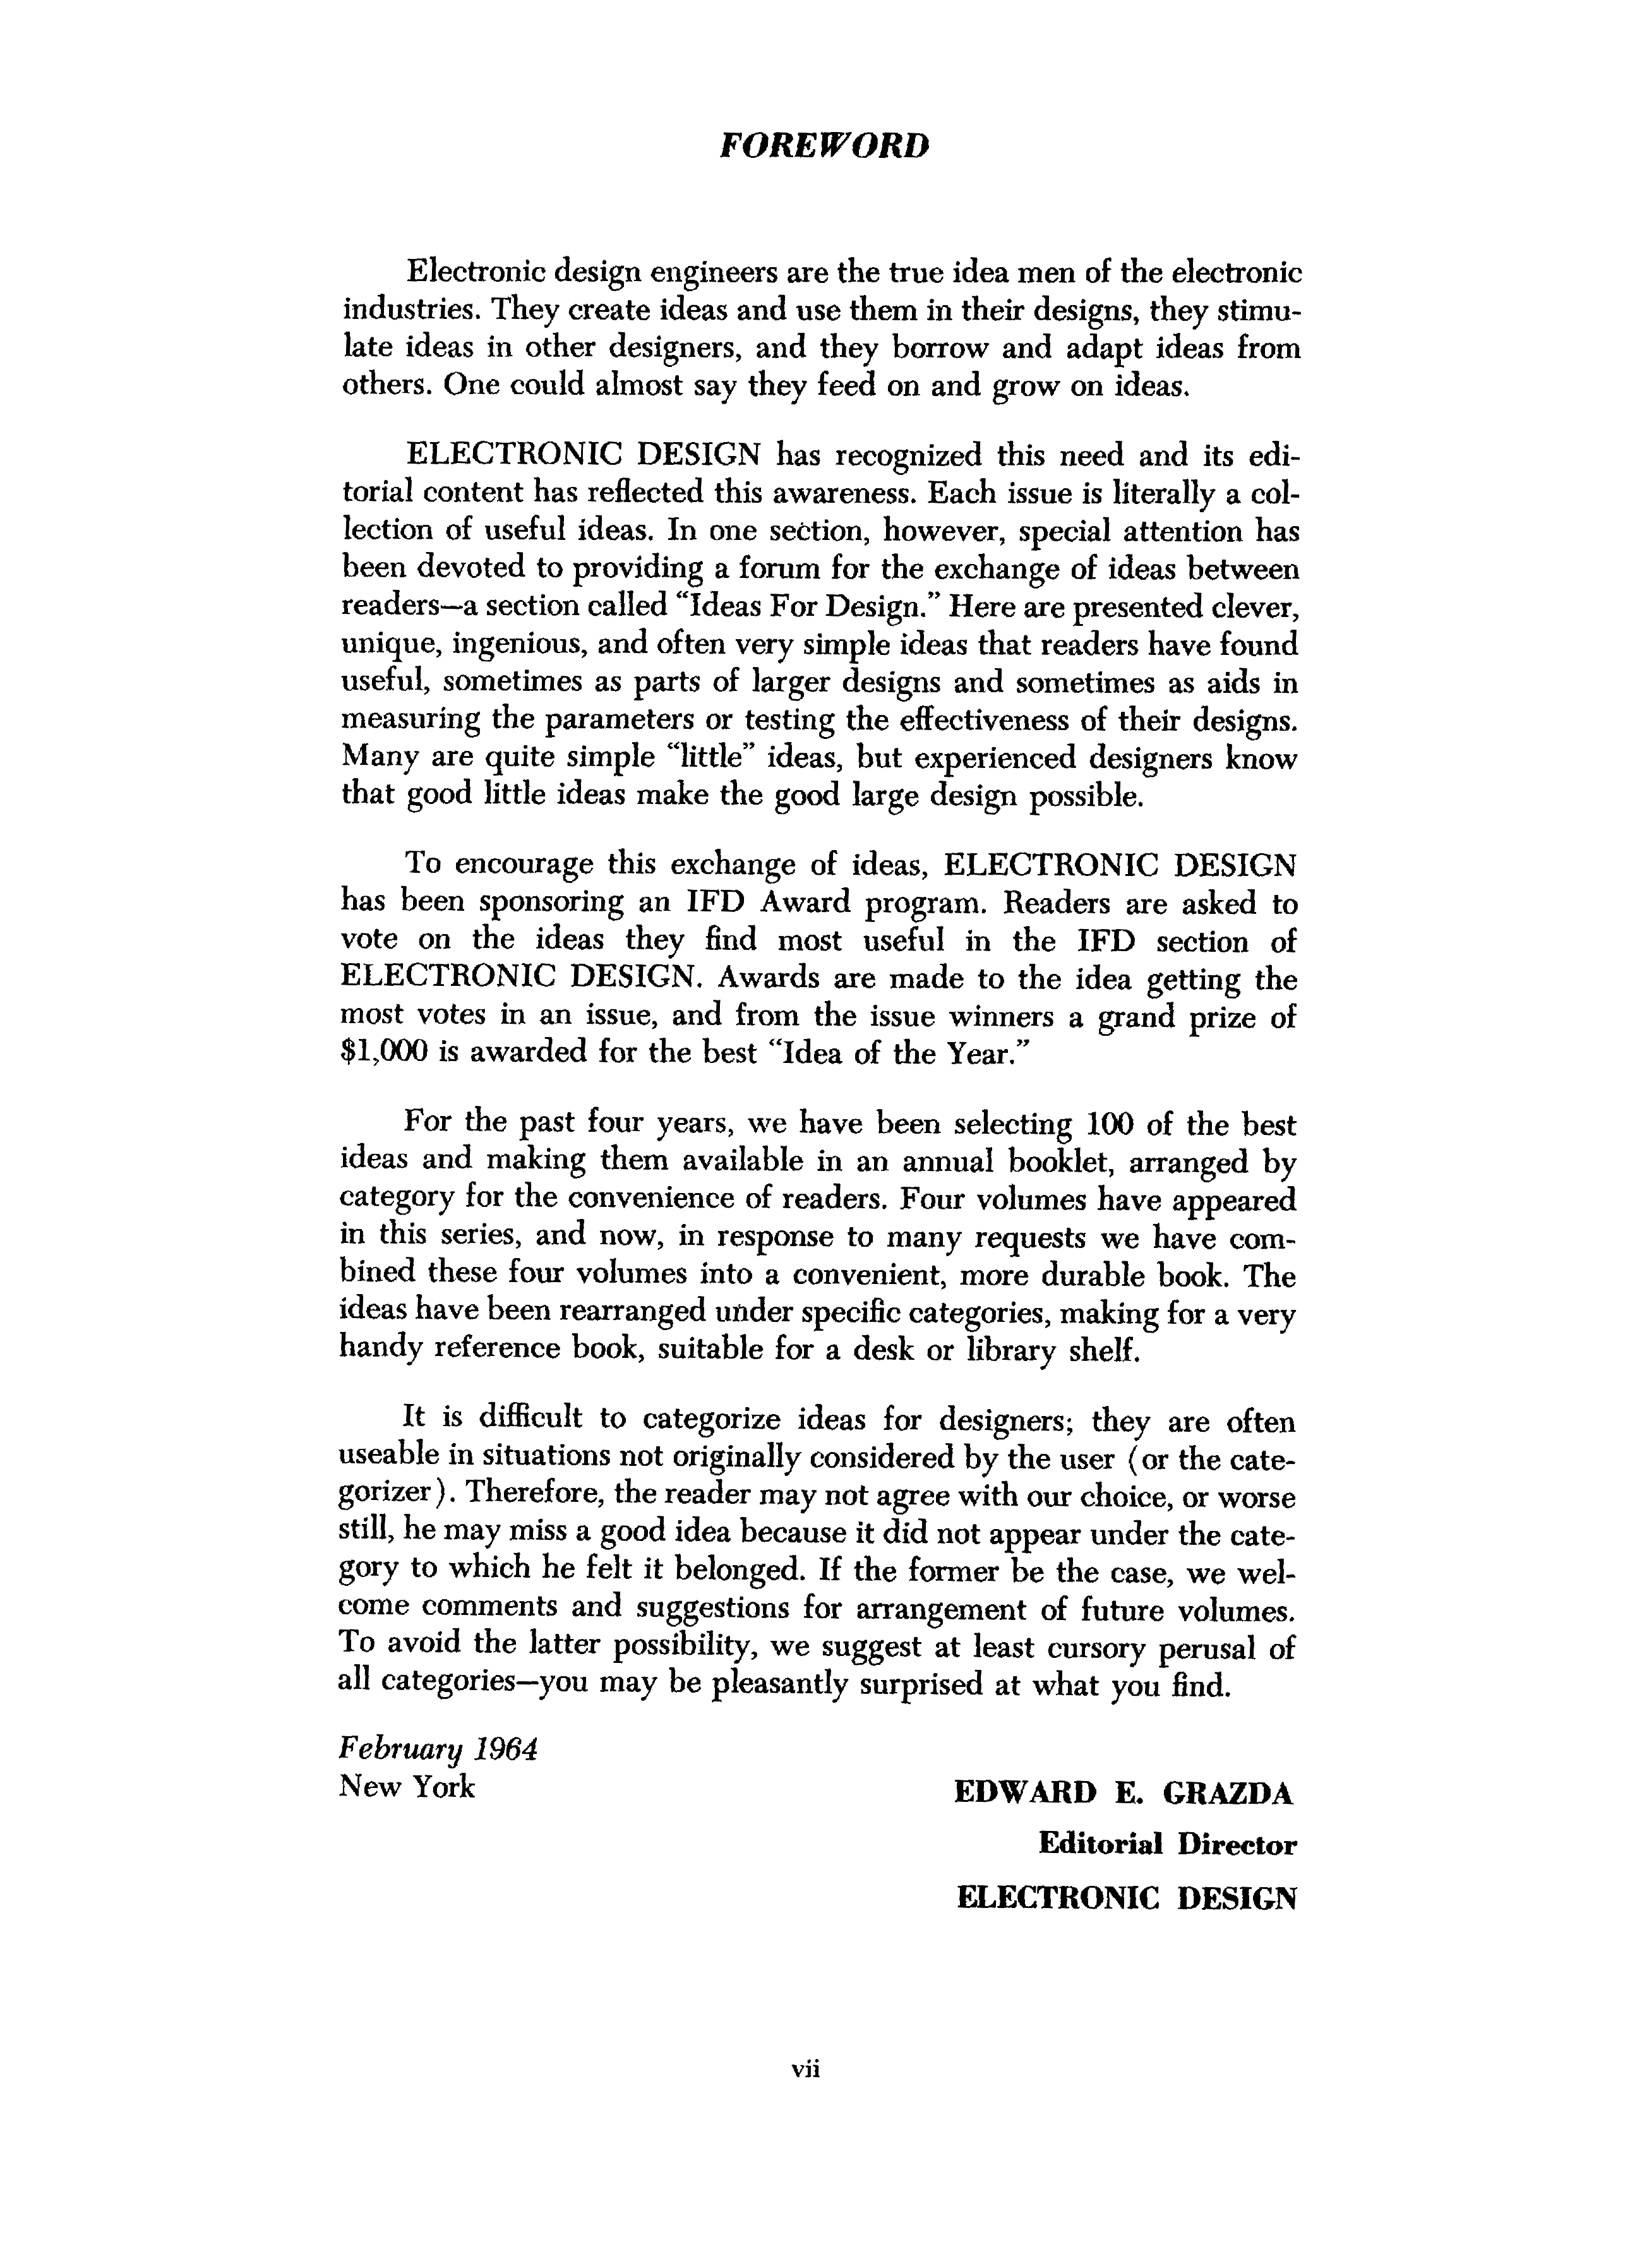

In [19]:
display_images(corrected_result, "corrected_image")

### Calculate scores for show difference

In [20]:
detected = "\n".join([row.text for row in result.collect()])
corrected_detected = "\n".join([row.text for row in corrected_result.collect()])

# read original text
path_to_pdf_rotated_text = pkg_resources.resource_filename('sparkocr', 'resources/ocr/pdfs/rotated/400.txt')

pdf_rotated_text = open(path_to_pdf_rotated_text, "r").read()

# compute scores
detected_score = score(pdf_rotated_text, detected)
corrected_score = score(pdf_rotated_text, corrected_detected)

#  print scores
print("Score without skew correction: {0}".format(detected_score))
print("Score with skew correction: {0}".format(corrected_score))

Score without skew correction: 0.7278876170655567
Score with skew correction: 0.995067817509248


## Image Text Cleaner

In [21]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/pdfs/noised.pdf


    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/tutorials/Certification_Trainings/noised.pdf
    Resolution: 300 dpi
    Width: 2479 px
    Height: 3508 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


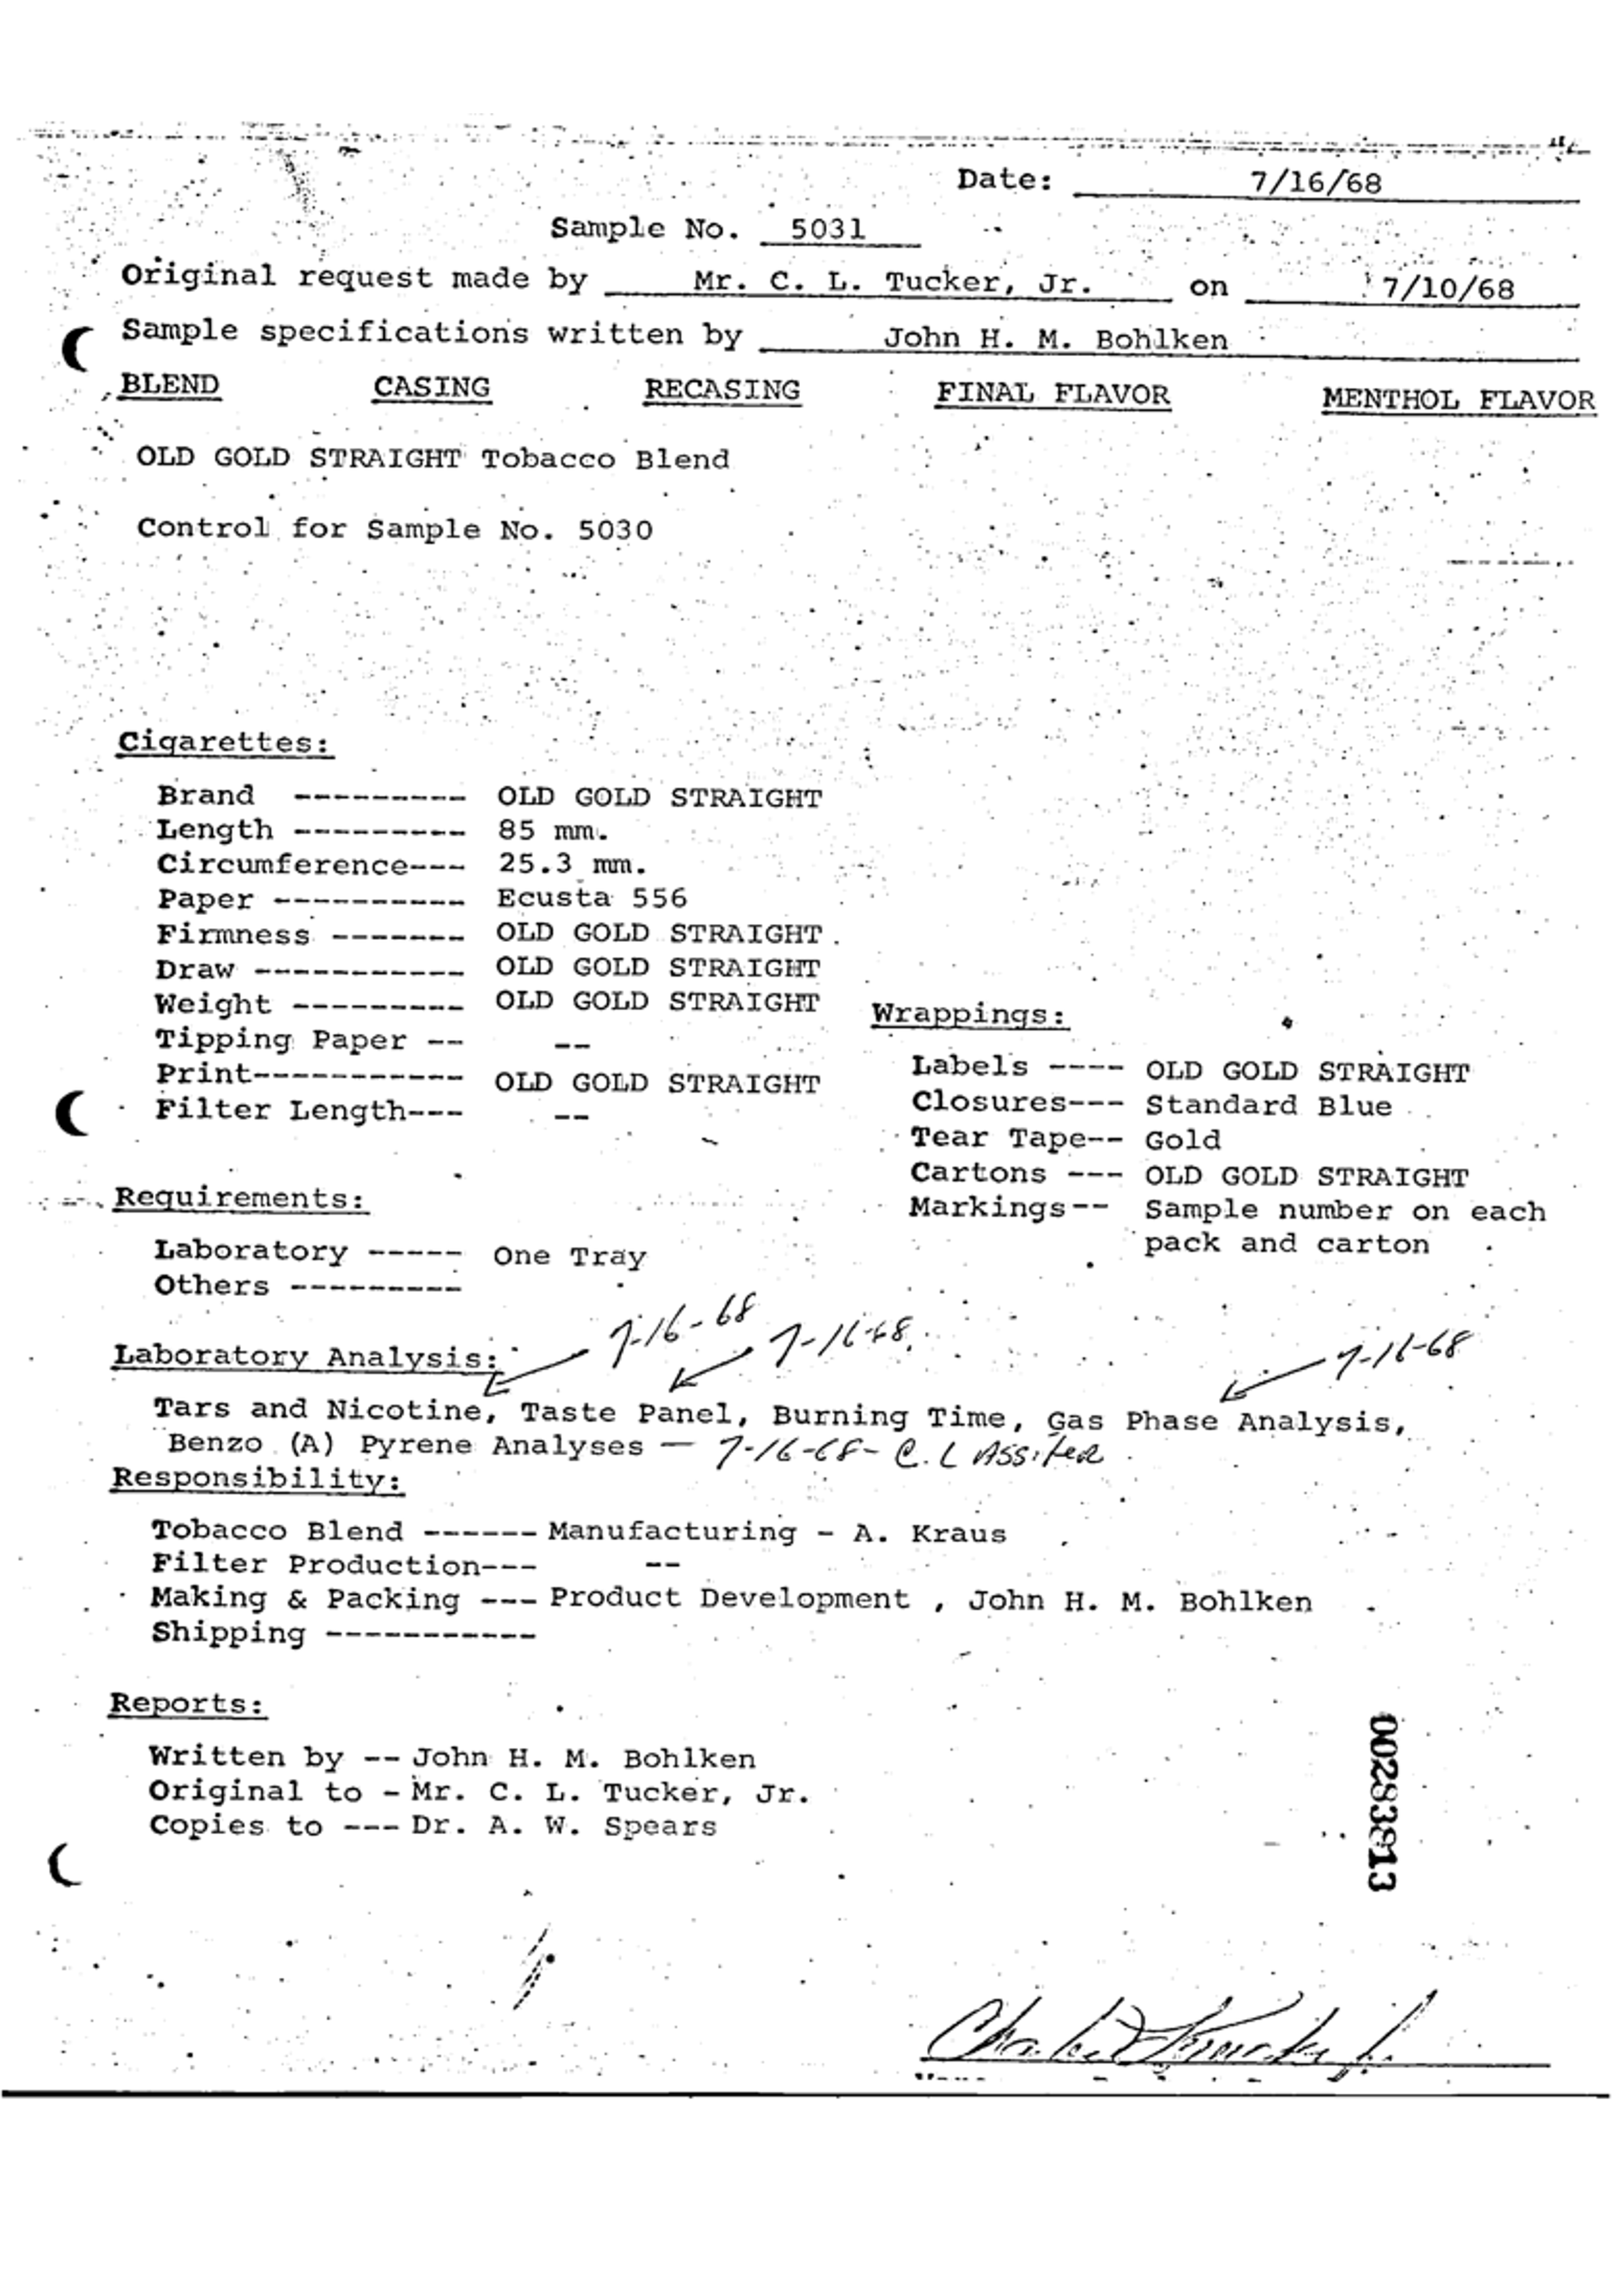

In [22]:
pdf_noised_df = spark.read.format("binaryFile").load('noised.pdf').cache()

display_pdf(pdf_noised_df)

In [23]:
pdf_to_image = PdfToImage() \
    .setInputCol("content") \
    .setOutputCol("image") \
    .setResolution(200)

ocr = ImageToText() \
    .setInputCol("image") \
    .setOutputCol("text") \
    .setConfidenceThreshold(70) \
    .setIgnoreResolution(False)

cleaner = ImageTextCleaner \
    .pretrained("text_cleaner_v1", "en", "clinical/ocr") \
    .setInputCol("image") \
    .setOutputCol("corrected_image") \
    .setMedianBlur(0) \
    .setSizeThreshold(10) \
    .setTextThreshold(0.3) \
    .setLinkThreshold(0.2) \
    .setPadding(5) \
    .setBinarize(False)

ocr_corrected = ImageToText() \
    .setInputCol("corrected_image") \
    .setOutputCol("corrected_text") \
    .setConfidenceThreshold(70) \
    .setIgnoreResolution(False)

pipeline = PipelineModel(stages=[
    pdf_to_image,
    ocr,
    cleaner,
    ocr_corrected
])

text_cleaner_v1 download started this may take some time.
Approximate size to download 73.5 MB


In [24]:
results = pipeline.transform(pdf_noised_df).cache()

print(f"Detected text:\n{results.select('text').collect()[0].text}")

Detected text:
 

 

 

Sample specifications written by
 , BLEND CASING RECASING

- OLD GOLD STRAIGHT Tobacco Blend

Control for Sample No. 5030

Cigarettes:

OLD GOLD STRAIGHT

 

John H. M. Bohlken

FINAL FLAVOR MENTHOL FLAVOR

Tars and Nicotine, Taste Panel, Burning Time, Gas Phase Analysis,
Benzo (A) Pyrene Analyses — T/C -CF~ O.C S51: Fee -

Written by -- John H. M. Bohlken
Original to -Mr. C. L. Tucker, dr.
Copies to ---Dr. A. W. Spears

C

~





    Image #0:
    Origin: file:/Users/nmelnik/IdeaProjects/spark-ocr/workshop/tutorials/Certification_Trainings/noised.pdf
    Resolution: 300 dpi
    Width: 2479 px
    Height: 3508 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


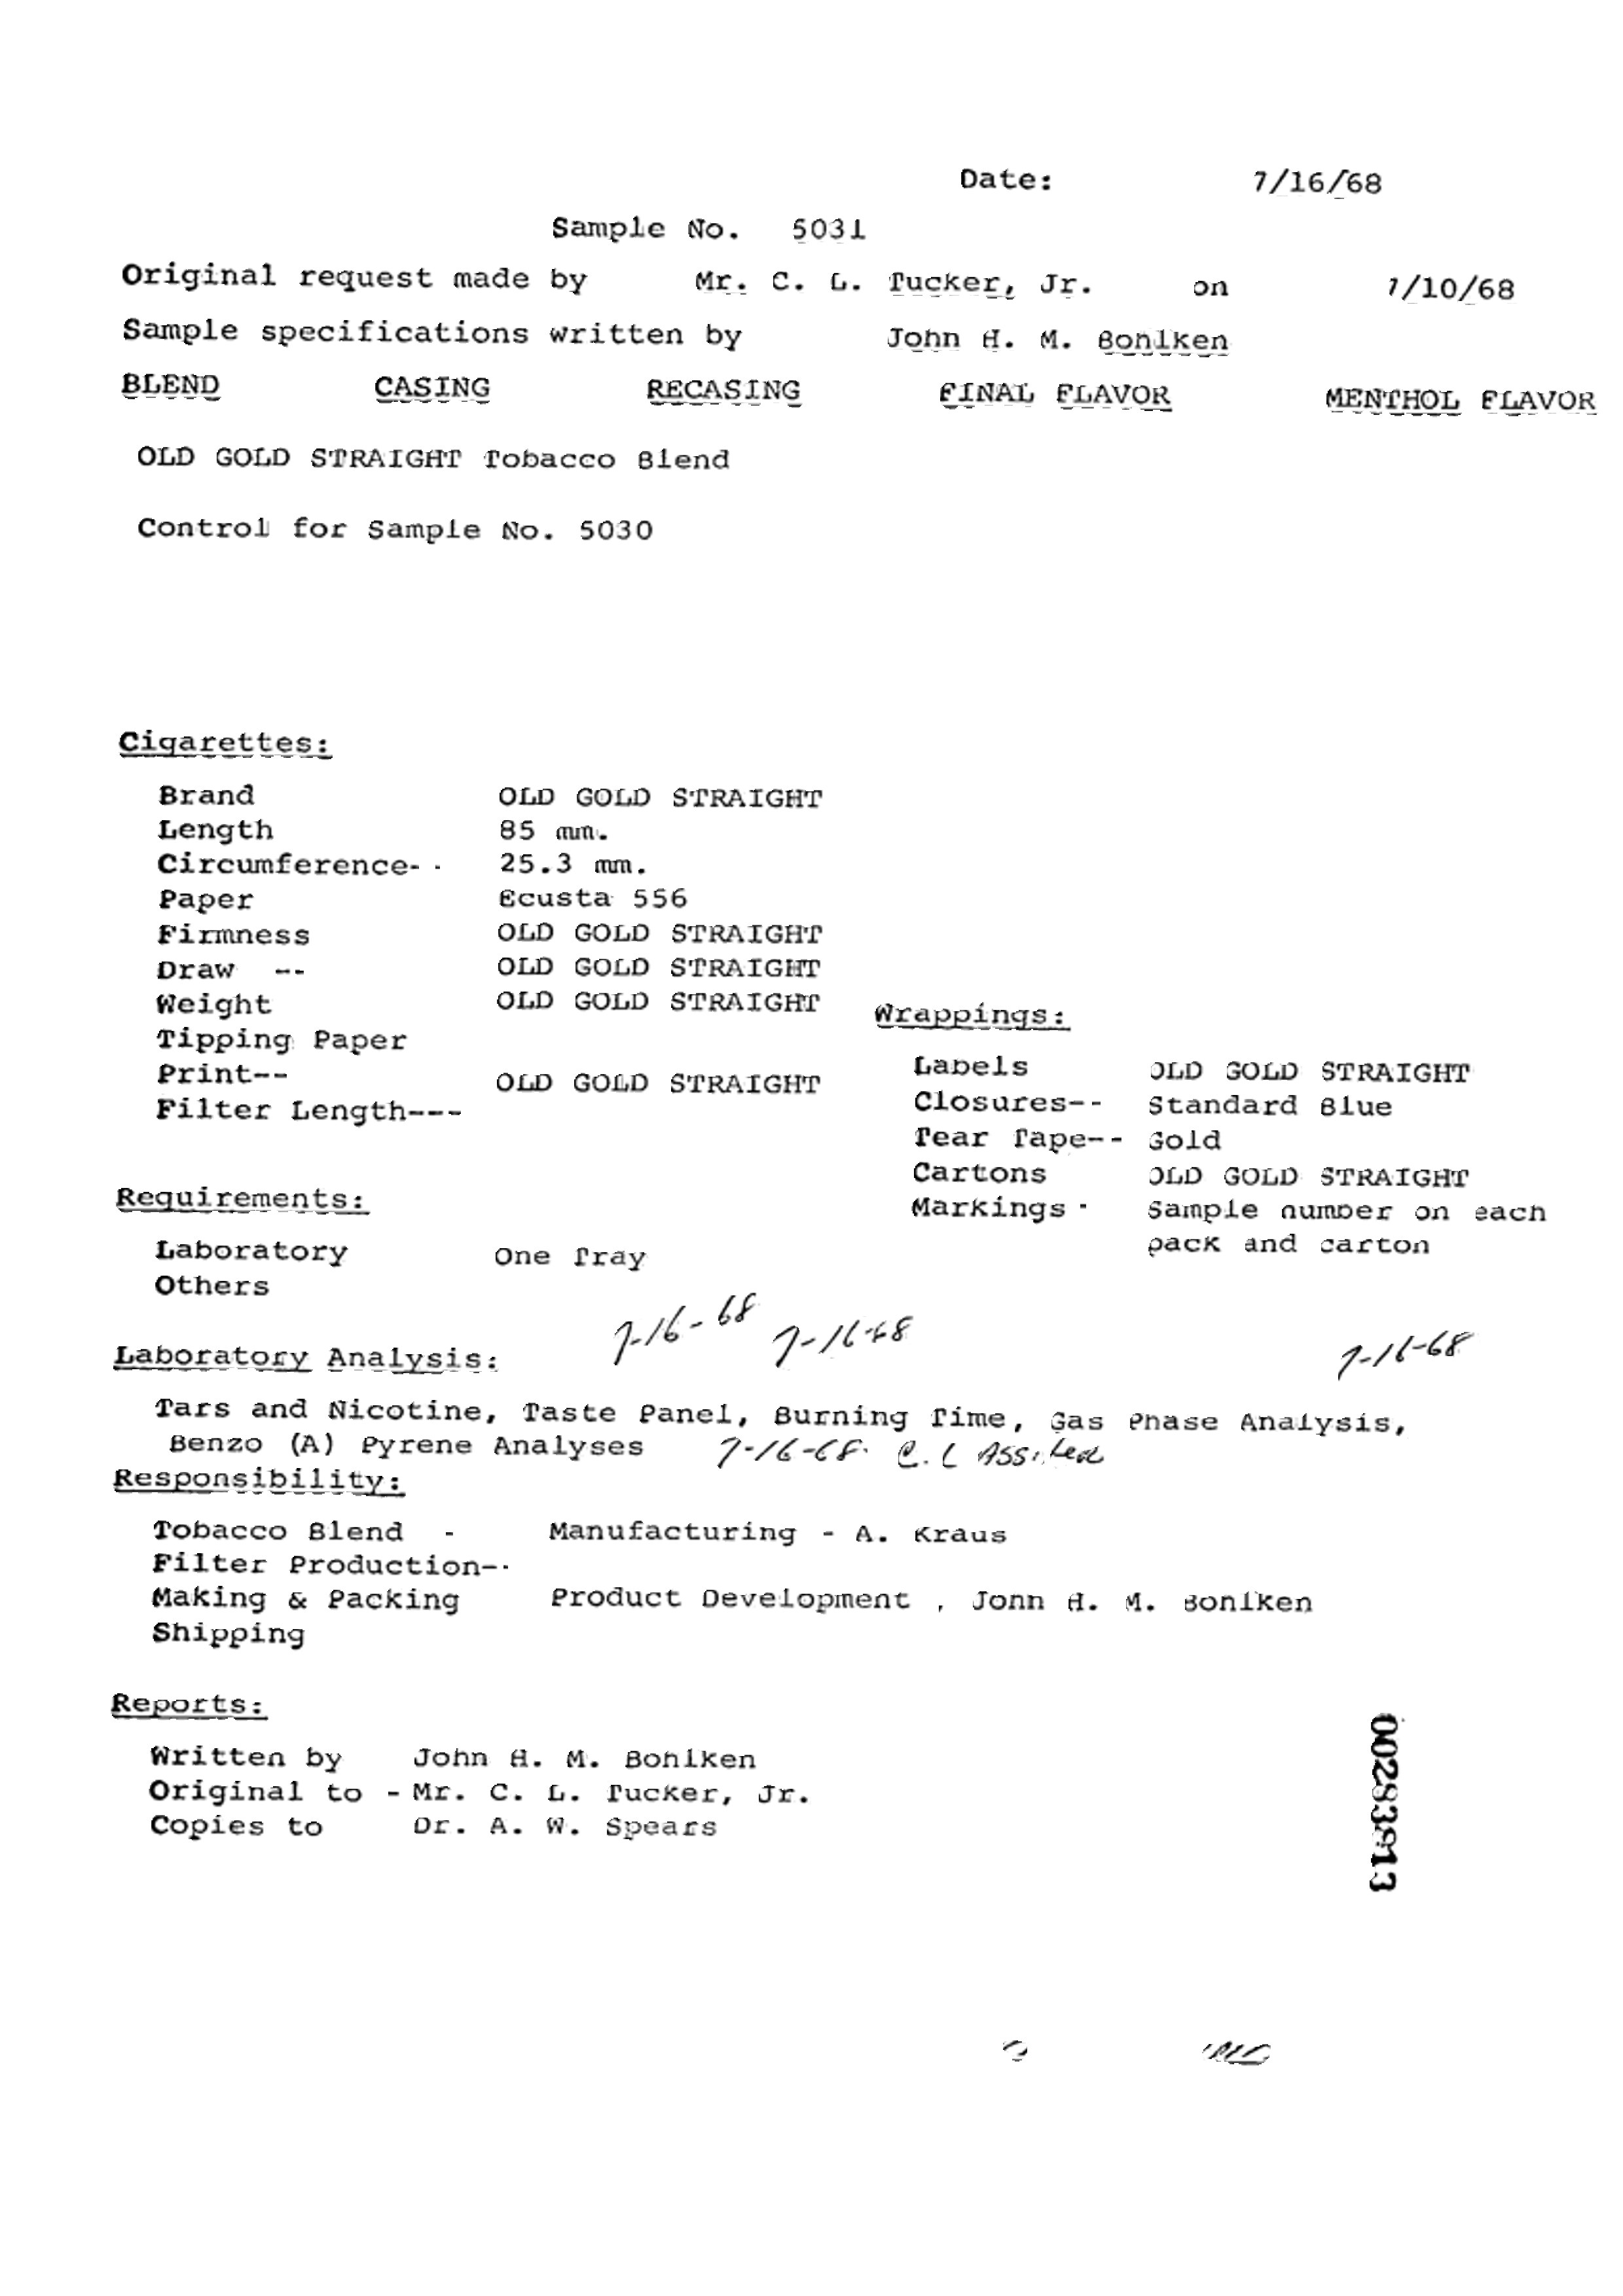

In [25]:
display_images(results, "corrected_image")

In [26]:
print(f"Detected text from corrected image:\n{results.select('corrected_text').collect()[0].corrected_text}")

Detected text from corrected image:
Date: 7/16/68
Sample Mo. 5031

Original request made by Mr. C. G. fucker, Jr. on 7/10/68
Sample specifications written by Jonn 4d. M. Bonlken
BLEND CASING RECASING FINAL FLAVOR MENTHOL FLAVOR

OLD GOLD STRAIGHT Tobacco Blend

Control for Sample No. 5030

Cigarettes:
Brand OLD GOLD STRAIGHT
Length 85 mn.
Circumference- - 25.3 mm.
Paper Ecusta 556
Fixrmness OLD GOLD STRAIGHT
Draw -- OLD GOLD STRAIGHT
Weight OLD GOLD STRAIGHT = @rappin 18:
Tipping Paper
Print-- OLD GOLD STRAIGHT fapels 2ED GOLD STRAIGHT
Filter Length--- Closures-- Standard Blue
Tear fape-- Gold
Cartons ILD GOLD STRAIGHT
Reguirements: Markings ~° Sample aumber on each
Laboratory One fray pack and carton
Others
L- bf “Lh
: Li eb flebE
Laboratory Analysis: 7-

Tars and Nicotine, Taste Panel, Burning fime, Gas enase Analysis,

Benzo (A) Pyrene Analyses JV SE-CF CC O55: “ee
Responsibility:

Tobacco Blend - Manufacturing - A. Kraus

Filter Production--
Making & Packing Product Development , J

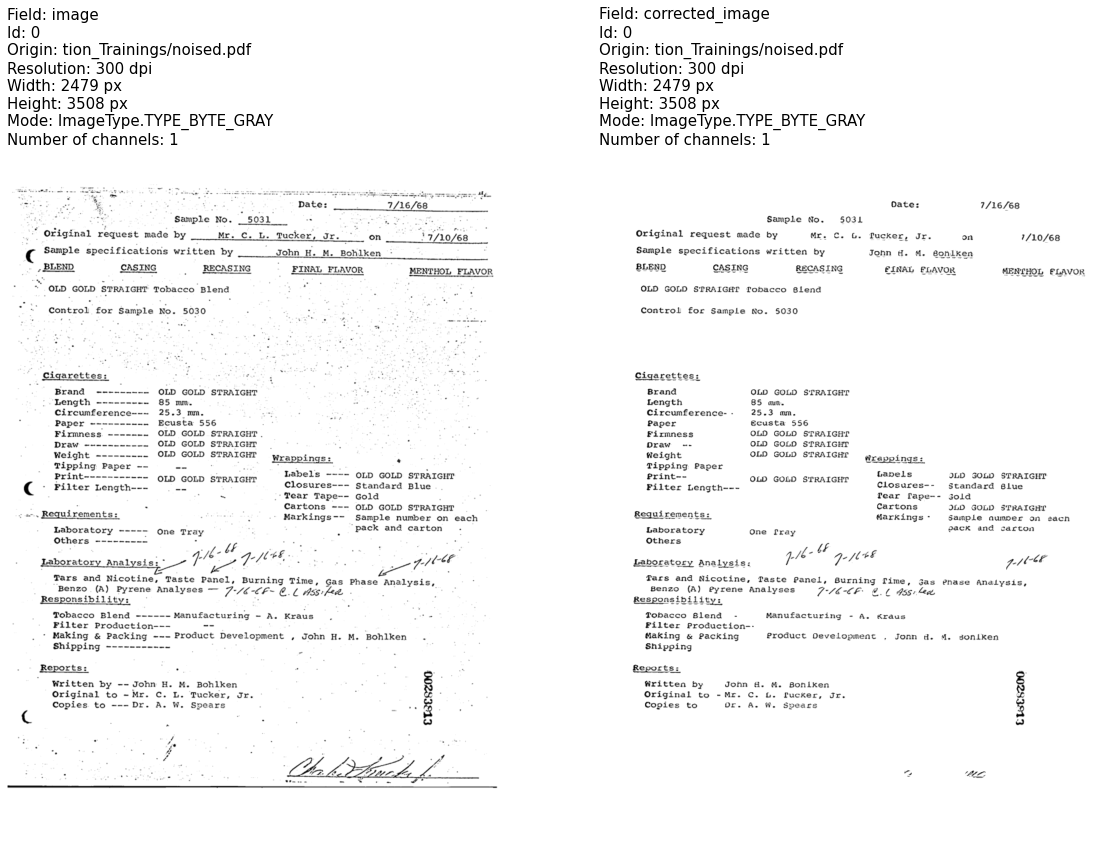

In [27]:
display_images_horizontal(results, "image,corrected_image")